In [25]:
import numpy as np
import scipy.optimize as opt
from scipy.integrate import quad
import CoolProp.CoolProp as CP
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
R = 8.314
#T = 373.15
#M = CP.PropsSI('molarmass','water')
#Tc = CP.PropsSI('Tcrit','water')
#pc = CP.PropsSI('Pcrit','water')
#omega = CP.PropsSI('acentric','water')
#b = 0.07780 * (R/M) * Tc / pc
#alpha = 1 + (0.37464 + 1.54226 * omega - 0.26992 * omega**2) * (1 - np.sqrt(T / Tc))
#a = 0.45724 *( (R * Tc/M) ** 2) * alpha ** 2 / pc

In [54]:
class pr_eos():
    def __init__(self,fluid,T):
        self.fluid = fluid
        self.T = T
    
    def pr_coefs(self):
        M = CP.PropsSI('molarmass',self.fluid)
        Tc = CP.PropsSI('Tcrit',self.fluid)
        pc = CP.PropsSI('Pcrit',self.fluid)        
        omega = CP.PropsSI('acentric',self.fluid)
        self.b = 0.07780 * (R/M) * Tc / pc
        alpha = 1 + (0.37464 + 1.54226 * omega - \
                     0.26992 * omega**2) * (1 - np.sqrt(self.T / Tc))
        self.a = 0.45724 *( (R * Tc/M) ** 2) * alpha ** 2 / pc   
        self.M = M
        return(self.a,self.b,self.M,self.T)    
    
    def p_sat(self,guess):
        p_sat = opt.fsolve(maxwell,guess)
        return(p_sat)

    
def vols(p_guess):
    a,b,M,T = pr.pr_coefs()
    Rw = R/M
    p = p_guess
    A_mult = p / (Rw * T) ** 2
    B_mult = p / (Rw * T)
    a3 = 1
    a2 = 1 - B_mult*b
    a1 = A_mult * a - 3 * (B_mult * b) ** 2 - 2 * B_mult * b
    a0 = A_mult * a * B_mult * b - (B_mult * b) ** 2 - (B_mult * b) ** 3
    coeff = [a3,-a2,a1,-a0]
    vol = np.roots(coeff) * Rw * T / p_guess
    v_l, v_v = np.min(vol), np.max(vol)
    return(v_l, v_v,a,b,M,T)

def maxwell(guess):
    v_l, v_v,a,b,M,T = vols(guess)
    integ = quad(lambda v: ((R/M) * T / (v - b) - a / (v**2 + 2*v*b - b**2)),v_l,v_v)
    return(integ[0] - guess*(v_v - v_l))

0.540878015009
0.656780446796
0.772682878584


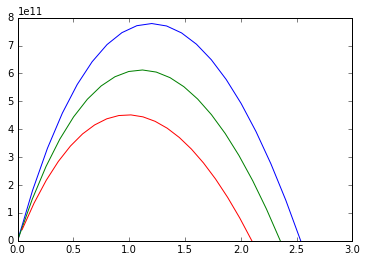

In [73]:
for temp in np.linspace(350,500,3):
    print(temp/CP.PropsSI('Tcrit','water'))
    pr = pr_eos('water',temp)
    psat = pr.p_sat(101325)
    v_l, v_v,a,b,M,T = vols(psat)
    rhoc = CP.PropsSI('rhocrit','water')
    rho_range = np.linspace(1/v_l,1/v_v,20)
    psi = []
    for k in rho_range:
        psi.append(k*quad(lambda rho: (rho*(R/M)*T/(1 - rho*b) - a * (rho / M)**2 /\
             (1 + 2 * rho * b - (rho * b)**2 ))/rho**2 - psat/rho**2,1/v_l,k)[0])
    plt.plot(rho_range/rhoc,psi)